<a href="https://colab.research.google.com/github/khalidpark/whitepaper-DeepLearning/blob/main/deep_learning_whitepapaer_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### BBC Dataset 로드 및 unzip

이번 세션에서는 BBC에서 제공하는 데이터셋을 사용하여 텍스트를 다뤄볼 예정입니다. BBC 웹사이트를 방문하는 고객이 방금 읽은 뉴스(문서)를 기반으로 비슷한 다른 문서를 적절하게 추천하게 만들 수 있으면 좋겠죠. 그런 작업을 한번 시작해 봅니다. 

* 아래 링크에서 파일을 다운로드 받아 노트 폴더에서 압축을 해제합니다. <br> data folder가 생성되고 001.txt ~ 401.txt 파일이 있는지 확인합니다.
* colab 유저들은 업로드 코드를 이용하여 업로드 후 unzip하여 파일을 풀면 사용할 수 있습니다.

* [bbc_fulltext.zip](https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/bbc_fulltext/bbc_fulltext.zip)


* 레퍼런스 - [BBC News Tech]('https://www.bbc.com/news/technology')
, D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006. [논문링크](http://mlg.ucd.ie/datasets/bbc.html)

In [1]:
# for Colab User
# Upload files
from google.colab import files
uploaded = files.upload()
!unzip "/content/bbc_fulltext.zip" # 업로드 이름이 다르다면 수정해서 사용하세요.

Saving bbc_fulltext.zip to bbc_fulltext (1).zip
Archive:  /content/bbc_fulltext.zip
   creating: data/
  inflating: data/289.txt            
  inflating: data/262.txt            
  inflating: data/276.txt            
  inflating: data/060.txt            
  inflating: data/074.txt            
  inflating: data/048.txt            
  inflating: data/114.txt            
  inflating: data/100.txt            
  inflating: data/128.txt            
  inflating: data/316.txt            
  inflating: data/302.txt            
  inflating: data/303.txt            
  inflating: data/317.txt            
  inflating: data/129.txt            
  inflating: data/101.txt            
  inflating: data/115.txt            
  inflating: data/049.txt            
  inflating: data/075.txt            
  inflating: data/061.txt            
  inflating: data/277.txt            
  inflating: data/263.txt            
  inflating: data/288.txt            
  inflating: data/275.txt            
  inflating: data/261.t

In [2]:
# data 폴더가 제대로 생성되었는 지 확인합니다. 
!ls

'bbc_fulltext (1).zip'	 bbc_fulltext.zip   data   sample_data


BoW를 사용해 Document Term Matrices(DTM, 문서-단어행렬)을 만들어 보겠습니다. 각 행은 문서를 나타내고 각 열은 단어를 나타냅니다.
- 각 셀의 값은 여러가지 방법으로 표현될 수 있는데
    - 단어의 출현 빈도를 나타내거나,
    - 단순히 단어의 존재 유무(binary)를 표현할 수 있고,
    - TF-IDF 값으로 나타낼 수 있습니다.



---



### spacy 예제
**Spacy로 텍스트에서 토큰을 추출해 보겠습니다.**

In [4]:
# 모듈에서 사용할 라이브러리와 spacy 모델을 불러옵니다.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load("en_core_web_sm")

In [5]:
# 예제로 사용할 Text를 선언합니다. 
text = "In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf."

In [6]:
# spacy의 언어모델을 이용하여 token화된 단어들을 확인합니다. 
doc = nlp(text)
print([token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)])

['information', 'retrieval', 'tf', 'idf', 'TFIDF', 'short', 'term', 'frequency', 'inverse', 'document', 'frequency', 'numerical', 'statistic', 'intend', 'reflect', 'important', 'word', 'document', 'collection', 'corpus', 'weight', 'factor', 'search', 'information', 'retrieval', 'text', 'mining', 'user', 'modeling', 'tf', 'idf', 'value', 'increase', 'proportionally', 'number', 'time', 'word', 'appear', 'document', 'offset', 'number', 'document', 'corpus', 'contain', 'word', 'help', 'adjust', 'fact', 'word', 'appear', 'frequently', 'general', 'tf', 'idf', 'popular', 'term', 'weight', 'scheme', 'today', 'survey', 'conduct', '2015', 'show', '83', 'text', 'base', 'recommender', 'system', 'digital', 'library', 'use', 'tf', 'idf']


#### BBC Dataset에 적용

데이터를 축적하는 함수를 제작합니다.

In [7]:
# BBC 데이터를 불러오기 위한 함수
import os 

def gather_data(filefolder):
    """ 폴더 내 텍스트 파일을 각각 리스트 요소에 저장하는 함수
    Args:
        filefolder (str): .txt 파일이 존재하는 경로
    Returns:
        문서를 요소로하는 리스트
    """
    
    data = []
    files = os.listdir(filefolder)
    for article in files: 
        path = os.path.join(filefolder, article)
        # txt로 끝나는 파일만 읽습니다
        if  path[-3:] == 'txt':
            # rb:Read the file in Binary mode
            with open(path, 'rb') as f:
                data.append(f.read())
    
    return data

In [8]:
data = gather_data('./data')

In [9]:
# 샘플 확인
data[0]

b'Intel unveils laser breakthrough\n\nIntel has said it has found a way to put a silicon-based laser on a chip, raising hopes of much faster networks.\n\nScientists at Intel have overcome a fundamental problem that before now has prevented silicon being used to generate and amplify laser light. The breakthrough should make it easier to interconnect data networks with the chips that process the information. The Intel researchers said products exploiting the breakthrough should appear by the end of the decade.\n\n"We\'ve overcome a fundamental limit," said Dr Mario Paniccia, director of Intel\'s photonics technology lab. Writing in the journal Nature, Dr Paniccia - and colleagues Haisheng Rong, Richard Jones, Ansheng Liu, Oded Cohen, Dani Hak and Alexander Fang - show how they have made a continuous laser from the same material used to make computer processors. Currently, says Dr Paniccia, telecommunications equipment that amplifies the laser light that travels down fibre optic cables is

문서별 단어의 수 분포도를 그려봅니다

In [10]:
import seaborn as sns
# plot 스타일과 폰트 크기를 설정합니다.
sns.set(style='whitegrid', font_scale=1.15)

# 문서별 단어의 수 분포도 그리는 함수
def plot_text_length_dist(text_list):

    # 문장이 요소인 리스트를 받아 각 문서의 단어 수를 가진 리스트를 만듭니다
    num_words = [len(doc.split()) for doc in text_list]
    
    sns.displot(num_words)
    plt.title('# of words per documents')
    plt.xlabel('Number of words')
    plt.ylabel('Number of documents')
    plt.show()       

대략 500 단어 정도로 표현된 문서가 가장 많이 보입니다.

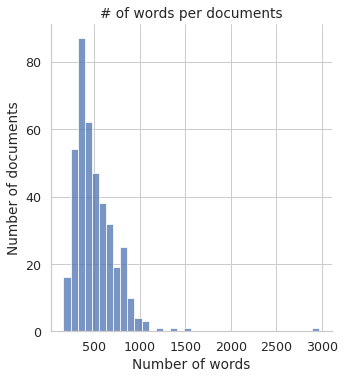

In [11]:
plot_text_length_dist(data)



---



### CountVectorizer 예제
: 단어들의 출현 빈도로 여러개의 문서를 벡터화하는 함수 <br>
: 모든 문자를 소문자로 전환하여 계산함

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# wiki 문장들을 리스트에 나누어 입력해봅니다. 
text = ["In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus."
,"It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling."
,"The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general."
,"tf–idf is one of the most popular term-weighting schemes today."
,"A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf."]

# CountVectorizer 생성
vect = CountVectorizer()

# text를 기반으로 어휘 사전을 생성
vect.fit(text) 
# vect.fit(data[:5])

# text를 DTM(document-term matrix)으로 변환(transform)
dtm = vect.transform(text)
# dtm = vect.transform(data[:5])

vocabulary(모든 토큰)와 맵핑된 인덱스 정보를 확인할 수 있습니다

In [13]:
vect.vocabulary_

{'2015': 0,
 '83': 1,
 'adjust': 2,
 'and': 3,
 'appear': 4,
 'appears': 5,
 'as': 6,
 'based': 7,
 'by': 8,
 'collection': 9,
 'conducted': 10,
 'contain': 11,
 'corpus': 12,
 'digital': 13,
 'document': 14,
 'documents': 15,
 'fact': 16,
 'factor': 17,
 'for': 18,
 'frequency': 19,
 'frequently': 20,
 'general': 21,
 'helps': 22,
 'how': 23,
 'idf': 24,
 'important': 25,
 'in': 26,
 'increases': 27,
 'information': 28,
 'intended': 29,
 'inverse': 30,
 'is': 31,
 'it': 32,
 'libraries': 33,
 'mining': 34,
 'modeling': 35,
 'more': 36,
 'most': 37,
 'number': 38,
 'numerical': 39,
 'of': 40,
 'offset': 41,
 'often': 42,
 'one': 43,
 'or': 44,
 'popular': 45,
 'proportionally': 46,
 'recommender': 47,
 'reflect': 48,
 'retrieval': 49,
 'schemes': 50,
 'searches': 51,
 'short': 52,
 'showed': 53,
 'some': 54,
 'statistic': 55,
 'survey': 56,
 'systems': 57,
 'term': 58,
 'text': 59,
 'tf': 60,
 'tfidf': 61,
 'that': 62,
 'the': 63,
 'times': 64,
 'to': 65,
 'today': 66,
 'use': 67,
 'us

In [14]:
dtm.shape

(5, 75)

추출된 토큰을 나열해 봅니다.

In [15]:
print(vect.get_feature_names())

['2015', '83', 'adjust', 'and', 'appear', 'appears', 'as', 'based', 'by', 'collection', 'conducted', 'contain', 'corpus', 'digital', 'document', 'documents', 'fact', 'factor', 'for', 'frequency', 'frequently', 'general', 'helps', 'how', 'idf', 'important', 'in', 'increases', 'information', 'intended', 'inverse', 'is', 'it', 'libraries', 'mining', 'modeling', 'more', 'most', 'number', 'numerical', 'of', 'offset', 'often', 'one', 'or', 'popular', 'proportionally', 'recommender', 'reflect', 'retrieval', 'schemes', 'searches', 'short', 'showed', 'some', 'statistic', 'survey', 'systems', 'term', 'text', 'tf', 'tfidf', 'that', 'the', 'times', 'to', 'today', 'use', 'used', 'user', 'value', 'weighting', 'which', 'word', 'words']


In [16]:
text[2]

'The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.'

dtm의 타입을 보면 compressed sparse Row matrix임을 알 수 있습니다. <br> csr: Compressed Sparse Row matrix, sparse matrix 형태에서 0을 표현하지 않습니다.

In [17]:
# CountVectorizer 로 제작한 dtm을 분석
type(dtm)

scipy.sparse.csr.csr_matrix

In [18]:
# (row, column)  count
print(dtm)

  (0, 9)	1
  (0, 12)	1
  (0, 14)	2
  (0, 18)	1
  (0, 19)	2
  (0, 23)	1
  (0, 24)	1
  (0, 25)	1
  (0, 26)	2
  (0, 28)	1
  (0, 29)	1
  (0, 30)	1
  (0, 31)	3
  (0, 39)	1
  (0, 44)	2
  (0, 48)	1
  (0, 49)	1
  (0, 52)	1
  (0, 55)	1
  (0, 58)	1
  (0, 60)	1
  (0, 61)	1
  (0, 62)	1
  (0, 65)	2
  (0, 73)	1
  :	:
  (3, 43)	1
  (3, 45)	1
  (3, 50)	1
  (3, 58)	1
  (3, 60)	1
  (3, 63)	1
  (3, 66)	1
  (3, 71)	1
  (4, 0)	1
  (4, 1)	1
  (4, 7)	1
  (4, 10)	1
  (4, 13)	1
  (4, 24)	1
  (4, 26)	2
  (4, 33)	1
  (4, 40)	1
  (4, 47)	1
  (4, 53)	1
  (4, 56)	1
  (4, 57)	1
  (4, 59)	1
  (4, 60)	1
  (4, 62)	1
  (4, 67)	1


0을 표현한 형태로 만들면 .todense를 사용할 수 있고, 이런경우 numpy.matrix형태가 됩니다. 

In [19]:
# Return a dense matrix representation
# dtm.todense()
print(type(dtm))
print(type(dtm.todense()))
dtm.todense()

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrix'>


matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 1, 2, 0,
         0, 0, 1, 1, 1, 2, 0, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
         0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
         1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
         1, 1, 0, 1, 0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2,
         7, 1, 2, 0, 0, 0, 0, 1, 0, 1, 2, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
         0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0

데이터프레임 형태로 결과를 보고 싶다면

In [20]:
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
print(type(dtm))
dtm

<class 'pandas.core.frame.DataFrame'>


,2015,83,adjust,and,appear,appears,as,based,by,collection,conducted,contain,corpus,digital,document,documents,fact,factor,for,frequency,frequently,general,helps,how,idf,important,in,increases,information,intended,inverse,is,it,libraries,mining,modeling,more,most,number,numerical,of,offset,often,one,or,popular,proportionally,recommender,reflect,retrieval,schemes,searches,short,showed,some,statistic,survey,systems,term,text,tf,tfidf,that,the,times,to,today,use,used,user,value,weighting,which,word,words
0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,0,0,0,1,2,0,0,0,1,1,1,2,0,1,1,1,3,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,1,1,0,0,2,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0
2,0,0,1,1,1,1,0,0,1,0,0,1,1,0,1,1,1,0,1,0,1,1,1,0,1,0,3,1,0,0,0,1,0,0,0,0,1,0,2,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,2,7,1,2,0,0,0,0,1,0,1,2,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0
4,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0


세번째 문장과, dtm을 비교해 보겠습니다. 

In [21]:
text[2]

'The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.'

#### BBC dataset에 적용

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

## stop_words = 'english' 영어에 해당하는 불용어 처리를 합니다.
## max_features=n, 빈도 순서대로 top n 단어만 사용합니다.
vect = CountVectorizer(stop_words='english'
                       , max_features=10000)
# fit & transform
dtm = vect.fit_transform(data)

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.shape

(401, 10000)

In [23]:
dtm.head()

,00,000,000s,0051,007,01,028,04m,05,0530,056,0630,080,0800,0870,10,100,1000,100m,100s,101,102,104,106,106cm,1080,10cm,10m,10s,10th,10x7in,11,110,115,117,11b,11m,12,120,120bn,...,yeob,yepp,yes,yesterday,yeun,yh,yle,yoda,yoga,yonca,yoran,york,yorker,young,younger,youngsters,youth,yuppy,yusuf,zafi,zander,zar,zdnet,zealous,zed,zelda,zen,zenith,zens,zero,zhang,zip,zodiac,zombie,zombies,zone,zonealarm,zones,zoom,zooms
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### TfidfVectorizer 예제

Term Frequency - Inverse Document Frequency ([TF-IDF](https://mungingdata.wordpress.com/2017/11/25/episode-1-using-tf-idf-to-identify-the-signal-from-the-noise/), 단어빈도-역문서빈도)


Warmup 보았던 영상의 내용을 정리해봅시다. 

-  TF(Term Frequency, 단어의 빈도) : 문서에서 단어가 많이 등장하는 지를 수치화한 중요도 스코어(score)
 <br> **특정 문서 d에서 특정 단어 t가 쓰인 빈도**:

$\large tf(t,d) = \frac{Term\; t\; frequency\; in\; document}{Total\; words\; in\; document}$

`ex) "A new car, used car, car reivew" `
  - TF score :  A($1 \over 7$), new($1 \over 7$), car($3 \over 7$), used($1 \over 7$), reivew($1 \over 7$)  
  - IDF - $log {(총 \space 문장 \space 개수) \over {(단어가 \space 출현한 \space 문장의 \space 개수)}}$
  $\large idf(t) = log(\frac{n}{1+df(t)})$
<br></br>
  
`ex) 'A'가 모든 문장에서 등장 IDF = log(N/N) = 0`<br>

- TF-IDF Score 
<br> $ = \large tf(t,d) \times idf(t)$
  <br> (t=단어, d=문서, n=총 문서수*)

`ex) TF-IDF score = TF * IDF = (1/7) * 0 = 0`


TF-IDF 를 사용하는 이유는 문서를 구분하는데 어떤 단어가 중요한지(**unique**) 찾는 것 입니다.

수식을 살펴보면, 
<br> 여러 문서에서 많이 등장하는 단어일 수록 중요도가 낮다고 판단하며(IDF), <br> 특정 문서에서만 자주 등장하는 단어는 중요도가 높다고 판단합니다(TF).

TF-IDF를 통한 자연어 처리는 간단하고 빠르게 구현할 수 있으므로 좋은 Baseline으로 사용할 수 있습니다.

#### TF-IDF vs Count vectorizer 


[1] TF-IDF(Tfidf) vectorizer를 생성하고 Document-Term Matrix (DTM)을 만들어 보겠습니다.

In [24]:
# TF-IDF vectorizer. 테이블을 작게 만들기 위해 max_features=15로 제한하였습니다.
tfidf = TfidfVectorizer(stop_words='english', max_features=15)

# Fit 후 dtm을 만듭니다.(문서, 단어마다 tf-idf 값을 계산합니다)
dtm = tfidf.fit_transform(text)

dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
dtm

,corpus,document,frequency,idf,information,number,recommender,reflect,retrieval,searches,term,text,tf,weighting,word
0,0.237982,0.475965,0.589946,0.166183,0.237982,0.000000,0.000000,0.294973,0.237982,0.000000,0.237982,0.000000,0.166183,0.000000,0.237982
1,0.000000,0.000000,0.000000,0.000000,0.425001,0.000000,0.000000,0.000000,0.425001,0.526778,0.000000,0.425001,0.000000,0.425001,0.000000
2,0.276074,0.276074,0.000000,0.192782,0.000000,0.684374,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.192782,0.000000,0.552149
3,0.000000,0.000000,0.000000,0.404837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.579748,0.000000,0.404837,0.579748,0.000000
4,0.000000,0.000000,0.000000,0.372642,0.000000,0.000000,0.661438,0.000000,0.000000,0.000000,0.000000,0.533644,0.372642,0.000000,0.000000


[2] 같은 파라미터로 CountVectorizer를 사용해 tfidf 결과와 비교해 보겠습니다.

In [25]:
vect = CountVectorizer(stop_words='english', max_features=15)
dtm = vect.fit_transform(text)
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm

,corpus,document,frequency,idf,information,number,recommender,reflect,retrieval,searches,term,text,tf,weighting,word
0,1,2,2,1,1,0,0,1,1,0,1,0,1,0,1
1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0
2,1,1,0,1,0,2,0,0,0,0,0,0,1,0,2
3,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0
4,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0


#### BBC Dataset에 적용

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
dtm = tfidf.fit_transform(data)
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

dtm.head()

,000,10,100,101,104,10m,11,12,120,13,130,14,149,15,150,16,167,17,17m,18,19,1980s,1982,1983,1985,1990s,1993,1994,1995,1bn,1m,20,200,2000,2001,2002,2003,2004,2005,2006,...,worry,worrying,worse,worst,worth,worthwhile,wouldn,wow,wright,wristwatch,write,writer,writers,writing,written,wrong,wrongful,wrote,wsis,x1,xbox,xenon,xp,xxx,yahoo,yang,year,years,yen,yes,yoda,yoran,york,young,younger,youngsters,youth,zafi,zen,zombies
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.030878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037613,0.0,0.0,0.0,0.0,0.0,0.032135,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.047534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.026999,0.026875,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.045337,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088027,0.0,0.0,0.0,0.018384,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.06484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096246,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.020270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.015653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




---



#### 파라미터 튜닝

> 이번에는 조금 더 파라미터를 튜닝하고, spacy tokenizer 를 사용해서 벡터화를 진행해 보겠습니다.




In [27]:
# spacy tokenizer 함수
def tokenize(document):
    
    doc = nlp(document)
    # punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True) and (token.is_alpha == True)]

파라미터 튜닝을 더 해보겠습니다. 여러 파라미터들을 변경해 가며 결과를 비교해 보십시오.

In [28]:
# ngram_range = (min_n, max_n), min_n 개~ max_n 개를 갖는 n-gram(n개의 연속적인 토큰)을 토큰으로 사용합니다.
# min_df = n, 최소 n개의 문서에 나타나는 토큰만 사용합니다
# max_df = .7, 70% 이상 문서에 나타나는 토큰은 제거합니다
tfidf = TfidfVectorizer(stop_words='english'
                        ,tokenizer=tokenize
                        ,ngram_range=(1,2)
                        ,max_df=.7
                        ,min_df=3
#                         ,max_features = 4000
                       )

dtm = tfidf.fit_transform(data)
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
dtm.head()

,-PRON-,abandon,ability,ability record,able,able access,able choose,able control,able handle,able offer,able play,able store,able thing,able use,able watch,absolutely,absorb,abuse,academic,academy,accept,acceptable,acceptance,access,access available,access datum,access device,access e,access grow,access home,access information,access internet,access medium,access mobile,access net,access point,access service,accessible,accident,acclaim,...,year launch,year microsoft,year million,year motorola,year new,year number,year old,year people,year portable,year predict,year real,year release,year report,year say,year service,year think,year time,year uk,year use,year year,yen,yepp,yes,york,york base,york state,york times,young,young americans,young people,young user,youngster,youth,zelda,zen,zen micro,zombie,zombie bot,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.047242,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.068127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032607,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
dtm.shape

(401, 7604)



---



## 유사도를 이용해 문서를 검색해 봅시다

네이버, 구글과 같은 검색엔진의 원리는 무엇입니까? 
<br> 검색어를 인터넷에 존재하는 여러 문서들과 단순히 같은지만 비교 하는것은 아닙니다. 쿼리와 문서들을 매칭(matching) 하는 방법은 여러가지가 있습니다. 그중 가장 클래식한 방법인 "유사도 측정 방법"을 시도해 봅니다. 
<br> 이를 위해 n-차원 거리를 사용하는 방법을 살펴보겠습니다.

### 코사인 유사도(Cosine Similarity, Brute Force 방법)

$\Large similarity=cos(Θ)=\frac{A⋅B}{||A||\ ||B||}=\frac{\sum_{i=1}^{n}{A_{i}×B_{i}}}{\sqrt{\sum_{i=1}^{n}(A_{i})^2}×\sqrt{\sum_{i=1}^{n}(B_{i})^2}}$

<img align="center" src="https://images.deepai.org/glossary-terms/cosine-similarity-1007790.jpg" width=700 title="Cosine Similarity" alt="https://deepai.org/machine-learning-glossary-and-terms/cosine-similarity">


코사인 유사도는 두 벡터(문서벡터) 간의 각의 코사인 값을 이용하여 구할 수 있는 유사도 입니다.
- 두 벡터(문서)가 
    - 완전히 같을 경우 1이며
    - 90도의 각을 이루면 0
    - 완전히 반대방향을 이루면 -1 입니다

#### TF-IDF 벡터 거리
TF-IDF 벡터들의 거리를 계산해 보겠습니다
[sklearn.metrics.pairwise.cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html#sklearn-metrics-pairwise-cosine-similarity)

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

# input, X:(n_samples_X, n_features)
distance_matrix  = cosine_similarity(dtm)

In [31]:
df = pd.DataFrame(distance_matrix)

유사도는 문서 x 문서 행렬로 표현됩니다

In [32]:
df.shape

(401, 401)

In [33]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400
0,1.000000,0.034447,0.007703,0.017142,0.018217,0.018096,0.020874,0.036420,0.016128,0.011207,0.016341,0.040603,0.016812,0.016484,0.039043,0.017832,0.005678,0.118890,0.054839,0.010746,0.008635,0.026338,0.327130,0.022133,0.025571,0.016423,0.006043,0.015175,0.036022,0.014931,0.023258,0.011597,0.026899,0.019597,0.051232,0.006198,0.015803,0.003725,0.017563,0.025428,...,0.011337,0.008867,0.007703,0.006846,0.017455,0.016920,0.028688,0.000812,0.031559,0.017644,0.028480,0.038755,0.004473,0.039185,0.032607,0.004090,0.010605,0.030746,0.009557,0.009743,0.025415,0.007806,0.025351,0.025839,0.031301,0.081853,0.006090,0.024202,0.054993,0.015407,0.012883,0.115822,0.010389,0.026227,0.016077,0.031845,0.028672,0.015417,0.031516,0.022365
1,0.034447,1.000000,0.011049,0.009521,0.171461,0.004997,0.031597,0.019554,0.019210,0.032082,0.015176,0.044894,0.008403,0.039339,0.043537,0.015666,0.018600,0.080380,0.039995,0.011877,0.012518,0.018631,0.003316,0.028792,0.046153,0.014931,0.046241,0.011647,0.014062,0.014766,0.015786,0.015376,0.020017,0.018541,0.017860,0.027877,0.057062,0.010694,0.016018,0.016909,...,0.055570,0.022447,0.011049,0.014738,0.008460,0.014622,0.015352,0.050612,0.002937,0.027065,0.012088,0.015947,0.008257,0.035614,0.058813,0.011409,0.017370,0.039347,0.024933,0.020673,0.012192,0.005718,0.103296,0.025150,0.024217,0.009897,0.038096,0.015969,0.009067,0.022175,0.021750,0.012416,0.038527,0.041706,0.031049,0.007895,0.015343,0.000783,0.017416,0.005987
2,0.007703,0.011049,1.000000,0.020387,0.034860,0.045687,0.012661,0.047797,0.027529,0.037706,0.025486,0.039720,0.020377,0.221306,0.162440,0.030675,0.034869,0.062122,0.052231,0.026017,0.034867,0.080583,0.012525,0.033794,0.080502,0.033094,0.101805,0.030047,0.026440,0.331298,0.111527,0.054679,0.149252,0.043853,0.040446,0.021795,0.034436,0.021537,0.026962,0.035467,...,0.224486,0.232277,1.000000,0.015233,0.010984,0.050916,0.017369,0.013646,0.009731,0.025101,0.027119,0.012474,0.037387,0.067536,0.050564,0.028516,0.016653,0.020413,0.055014,0.030402,0.020788,0.029590,0.026868,0.030404,0.088159,0.066668,0.108880,0.036741,0.028326,0.027325,0.026530,0.019644,0.242450,0.109435,0.017996,0.053408,0.017359,0.026759,0.016779,0.063597
3,0.017142,0.009521,0.020387,1.000000,0.035249,0.117260,0.026629,0.042349,0.034842,0.011271,0.041928,0.044431,0.033833,0.048723,0.048182,0.022398,0.026784,0.047594,0.061882,0.034430,0.022916,0.013047,0.034932,0.104380,0.016294,0.044273,0.024162,0.017295,0.127722,0.018583,0.052831,0.016656,0.012850,0.302149,0.041559,0.130912,0.061349,0.042653,0.245535,0.045955,...,0.019564,0.019734,0.020387,0.032006,0.074491,0.195158,0.052334,0.018240,0.023897,0.043566,0.012514,0.094953,0.019380,0.127774,0.026041,0.027844,0.038340,0.048161,0.067801,0.023939,0.023823,0.048990,0.051009,0.089321,0.015992,0.058934,0.021005,0.116095,0.033090,0.023979,0.031981,0.055005,0.030023,0.022261,0.035359,0.136792,0.052305,0.024898,0.027592,0.057800
4,0.018217,0.171461,0.034860,0.035249,1.000000,0.047280,0.016895,0.041819,0.017915,0.037943,0.052614,0.038039,0.014976,0.069944,0.072599,0.018032,0.012110,0.067355,0.045777,0.018924,0.029708,0.021295,0.032804,0.089354,0.046376,0.056489,0.041170,0.027140,0.033266,0.049501,0.031013,0.029541,0.028042,0.066369,0.030637,0.021205,0.041600,0.041262,0.050066,0.052207,...,0.036734,0.024517,0.034860,0.023693,0.023114,0.053222,0.038611,0.122290,0.021011,0.040336,0.022806,0.016785,0.025519,0.071922,0.030427,0.036703,0.024588,0.089381,0.061372,0.033788,0.029394,0.045931,0.099497,0.103611,0.046522,0.053078,0.063935,0.076313,0.044819,0.087113,0.055848,0.041709,0.038840,0.045356,0.021991,0.032771,0.038590,0.018740,0.019547,0.032335


#### 문서간 유사도 측정
문서0과 문서0은 같으므로 유사도가 1입니다. 문서0과 문서1~4 와의의 유사도를 확인해 보세요.

In [34]:
df[0][:5]

0    1.000000
1    0.034447
2    0.007703
3    0.017142
4    0.018217
Name: 0, dtype: float64

#### 유사도를 이용한 정렬

문서0과 유사도가 큰 문서를 순서대로 정렬해서 살펴보겠습니다 (TF-IDF vectorization 방법에 따라 많이 다를 수 있습니다)

In [35]:
ind = df[df[0] < 1][0].sort_values(ascending=False)[:5]
ind

0      1.000000
293    0.991981
22     0.327130
126    0.148329
117    0.123663
Name: 0, dtype: float64

In [36]:
index = 377

In [37]:
print(data[0][:100])
print(data[index][:100])

b'Intel unveils laser breakthrough\n\nIntel has said it has found a way to put a silicon-based laser on '
b"New Year's texting breaks record\n\nA mobile phone was as essential to the recent New Year's festiviti"


코사인 유사도와 같은 Brute Force 방법은 비교해야 할 문서의 양이 많아 질 수록 많은 계산을 필요로합니다. <br> 실제 어플리케이션 환경에서는 더 빠른 비교 방법을 사용해야 합니다.

### NearestNeighbor (K-NN, K-최근접 이웃) 

K-최근접 이웃법은 쿼리와 가장 가까운 상위 K개의 근접한 데이터를 찾아서 K개 데이터의 유사성을 기반으로 **점을 추정하거나 분류**하는 예측 분석에 사용됩니다.
최근접 이웃 방법은 non-generalizing 머신러닝 방법인데, 모든 학습 데이터를 KD Tree 나 Ball Tree같은 빠른 색인 구조(indexing structure)에 단순히 저장하기 때문입니다.




[K-D Tree](https://scikit-learn.org/stable/modules/neighbors.html?highlight=very%20distant%20from%20point#k-d-tree)의 기본아이디어는 점 A와 B가 멀고, B가 C와 가까우면 A가 C와 멀다는 것을 알 수 있는데 이때 명시적으로 A와 C의 거리를 계산할 필요가 없다는 것입니다.

<img src="https://i.imgur.com/CKKoz5W.png" width="500"/>

[Ball Tree](https://scikit-learn.org/stable/modules/neighbors.html?highlight=very%20distant%20from%20point#ball-tree)는 K-D 트리를 더욱 효율적으로 만들기 위해 개발되었습니다. KD 트리는 데이터를 Cartesian 축으로 분할하지만 Ball Tree는 nesting hyper-spheres 형태로 분할하여 트리구성에 비용이 더 들지만, 매우 구조화된 데이터나 높은 차원의 데이터에 더 효율적입니다.

In [38]:
dtm.head()

,-PRON-,abandon,ability,ability record,able,able access,able choose,able control,able handle,able offer,able play,able store,able thing,able use,able watch,absolutely,absorb,abuse,academic,academy,accept,acceptable,acceptance,access,access available,access datum,access device,access e,access grow,access home,access information,access internet,access medium,access mobile,access net,access point,access service,accessible,accident,acclaim,...,year launch,year microsoft,year million,year motorola,year new,year number,year old,year people,year portable,year predict,year real,year release,year report,year say,year service,year think,year time,year uk,year use,year year,yen,yepp,yes,york,york base,york state,york times,young,young americans,young people,young user,youngster,youth,zelda,zen,zen micro,zombie,zombie bot,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.047242,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.068127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032607,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### sklearn - NearestNeighbors
sklearn에서 비지도학습을 위한 NearestNeighbors 모델을 사용합니다
[sklearn.neighbors.NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn-neighbors-nearestneighbors)

In [39]:
from sklearn.neighbors import NearestNeighbors

# dtm을 사용히 NN 모델을 학습시킵니다. (디폴트)최근접 5 이웃.
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

문서0과 가장 가까운 문서 (0 포함) 5개의 거리(값이 작을수록 유사합니다)와, 문서의 인덱스를 알 수 있습니다

In [40]:
nn.kneighbors([dtm.iloc[0].values])

(array([[0.        , 0.12664227, 1.16006044, 1.30512113, 1.32388569]]),
 array([[  0, 293,  22, 126, 117]]))

문서0의 이웃인 문서377로 검색해 보겠습니다 

In [41]:
nn.kneighbors([dtm.iloc[377]])

(array([[0.        , 1.10359349, 1.10359349, 1.17681006, 1.25274234]]),
 array([[377, 225,  19, 332, 163]]))

In [42]:
print(data[222][:300])
print(data[301][:300])

b'Global blogger action day called\n\nThe global web blog community is being called into action to lend support to two imprisoned Iranian bloggers.\n\nThe month-old Committee to Protect Bloggers\' is asking those with blogs to dedicate their sites on 22 February to the "Free Mojtaba and Arash Day". Arash S'
b"Dublin hi-tech labs to shut down\n\nDublin's hi-tech research laboratory, Media Labs Europe, is to shut down.\n\nThe research centre, which was started by the Irish government and the Massachusetts Institute of Technology, was a hotbed for technology concepts. Since its opening in 2000, the centre has d"


#### 문서 검색 예제

CNN 에서 tech 기사를 가져와서 문서검색에 사용해봅시다. 다른 기사를 가지고 테스트해봐도 좋습니다. 

In [43]:
# https://edition.cnn.com/2020/07/30/tech/huawei-samsung-q2-hnk-intl/index.html
cnn_tech_article = [ """
Hong Kong (CNN Business)Huawei became the world's top smartphone seller last quarter, overtaking Samsung for the first time ever, according to an independent market research report released Thursday.
The Chinese tech company shipped 55.8 million phones in the three months ended in June, surpassing longtime rival Samsung, which shipped 53.7 million, according to the Canalys report.
"Taking first place is very important for Huawei," said Canalys analyst Mo Jia. "It is desperate to showcase its brand strength to domestic consumers, component suppliers and developers."
A years-long US pressure campaign against Huawei has handicapped the Shenzhen-based firm's global business.
Huawei still suffered an annual decline in smartphone shipments of 5%. But Samsung's was a lot bigger at 30%, according to Canalys.
The market research firm said Huawei's victory over Samsung wouldn't have happened without Covid-19. The company was able to take advantage of the economic recovery in China, where Huawei now sells over 70% of its smartphones. Samsung has a very small presence in China.
Huawei&#39;s hopes of global domination have been dashed
Huawei's hopes of global domination have been dashed
Huawei's global smartphone and telecom gear business continues to suffer the fallout from US sanctions that cut the company off from key American tech and supplies.
Without access to popular Google (GOOGL GOOGLE) apps such as YouTube, maps and Gmail, Huawei's latest smartphones are a lot less attractive to international buyers. That will make it very difficult for Huawei to hold on to the global No. 1 position, according to Jia.
"It will be hard for Huawei to maintain its lead in the long term. Its major channel partners in key regions, such as Europe, are increasingly wary of ranging Huawei devices, taking on fewer models, and bringing in new brands to reduce risk. Strength in China alone will not be enough to sustain Huawei at the top once the global economy starts to recover," he said.
"Our business has demonstrated exceptional resilience in these difficult times," Huawei spokeswoman Evita Cao said. Cao did not respond to questions on how the company can maintain its lead going forward.
Huawei's victory came on the same day Samsung posted a big profit bump for the second quarter, with strong chip demand helping the company weather the fallout from the coronavirus pandemic.
Samsung reported operating profit of 8.15 trillion won ($6.8 billion) for the three months that ended in June, up more than 23% compared to the same period last year.
Samsung said sales fell about 6% to 53 trillion won ($44.6 billion).
Shares in Samsung were last up 0.7% in Seoul. South Korea's Kospi (KOSPI) rose 0.1%.
Taiwan&#39;s TSMC is becoming one of the world&#39;s top companies. Intel&#39;s problems are helping
Taiwan's TSMC is becoming one of the world's top companies. Intel's problems are helping
Despite the double digit declines in annual smartphone shipments for the quarter noted by the Canalys report, Samsung reported that the unit remained profitable thanks to savings on marketing costs. (Samsung does not break out specifics about its smartphone shipments, but noted that they declined.)
For the second half of 2020, however, Samsung is warning that "uncertainties related to Covid-19 linger" for its mobile business.
That could be enough to drag the company to revenue losses for the year, according to research firm Crisp Idea.
The consumer electronics unit, which includes smartphones and TVs, is "expected to decline significantly as Covid-19 affects demand and leads to store and plant closures globally," Crisp Idea analysts wrote in a note earlier this month.
Smartphone shipments worldwide are expected to fall about 18% in the first half of the year as the pandemic continues to affect consumer spending, analysts at IDC said in a note last month.
The market research firm added that global smartphone shipments are not expected to return to growth until the first quarter of 2021.
That would also hurt Samsung's memory chip business, because the company supplies chips for rival smartphone companies such as Apple (AAPL) and Huawei."""]


CNN Tech 뉴스를 쿼리로 쓰기 위해 학습된 tfidf vectorizer를 통해 변환하겠습니다

In [44]:
new = tfidf.transform(cnn_tech_article)

In [45]:
nn.kneighbors(new.todense())

(array([[1.31624638, 1.3174223 , 1.31770469, 1.31778057, 1.31848904]]),
 array([[240, 251, 185, 228, 330]]))

In [46]:
# 가장 가깝게 나온 문서를 확인합니다 
data[297]

b"Progress on new internet domains\n\nBy early 2005 the net could have two new domain names.\n\nThe .post and .travel net domains have been given preliminary approval by the net's administrative body. The names are just two of a total of 10 proposed domains that are being considered by the Internet Corporation for Assigned Names and Numbers, Icann. The other proposed names include a domain for pornography, Asia, mobile phones, an anti-spam domain and one for the Catalan language and culture.\n\nThe .post domain is backed by the Universal Postal Union that wants to use it as the online marker for every type of postal service and to help co-ordinate the e-commerce efforts of national post offices.\n\nThe .travel domain would be used by hotels, travel firms, airlines, tourism offices and would help such organisations distinguish themselves online. It is backed by a New York-based trade group called The Travel Partnership. Icann said its early decision on the two domains was in response to

---